In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import matplotlib.pyplot as plt


In [2]:
def preprocess_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [128, 128], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0  # Normalize mask to [0, 1]

    return image, mask


In [3]:
def load_dataset_unet(image_folder, mask_folder):
    image_paths = sorted([os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.jpg')])
    mask_paths = sorted([os.path.join(mask_folder, fname.replace('.jpg', '.png')) for fname in os.listdir(image_folder) if fname.endswith('.jpg')])
    return image_paths, mask_paths


In [4]:
def verify_and_clean_paths(image_paths, mask_paths):
    verified_image_paths = []
    verified_mask_paths = []
    
    for img_path, mask_path in zip(image_paths, mask_paths):
        if os.path.exists(img_path) and os.path.exists(mask_path):
            verified_image_paths.append(img_path)
            verified_mask_paths.append(mask_path)
        else:
            print(f"Missing file: {img_path} or {mask_path}")
    
    return verified_image_paths, verified_mask_paths


In [5]:
def create_tf_dataset(image_paths, mask_paths, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda image_path, mask_path: tf.py_function(preprocess_image_and_mask, [image_path, mask_path], [tf.float32, tf.float32]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(lambda image, mask: (tf.ensure_shape(image, [128, 128, 3]), tf.ensure_shape(mask, [128, 128, 1])),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


In [6]:
train_image_paths, train_mask_paths = load_dataset_unet('dataset/train', 'dataset/train/masks')
valid_image_paths, valid_mask_paths = load_dataset_unet('dataset/valid', 'dataset/valid/masks')
test_image_paths, test_mask_paths = load_dataset_unet('dataset/test', 'dataset/test/masks')

train_image_paths, train_mask_paths = verify_and_clean_paths(train_image_paths, train_mask_paths)
valid_image_paths, valid_mask_paths = verify_and_clean_paths(valid_image_paths, valid_mask_paths)
test_image_paths, test_mask_paths = verify_and_clean_paths(test_image_paths, test_mask_paths)


Missing file: dataset/train\Highway_1001_2020-07-30_jpg.rf.3f7c7a79129f26f572da959136dcb95d.jpg or dataset/train/masks\Highway_1001_2020-07-30_jpg.rf.3f7c7a79129f26f572da959136dcb95d.png
Missing file: dataset/train\Highway_1297_2020-07-30_jpg.rf.147665b755571c2aabede13b85cdbf71.jpg or dataset/train/masks\Highway_1297_2020-07-30_jpg.rf.147665b755571c2aabede13b85cdbf71.png
Missing file: dataset/train\Highway_1299_2020-07-30_jpg.rf.888ef887a35c7491cb8ea60369507909.jpg or dataset/train/masks\Highway_1299_2020-07-30_jpg.rf.888ef887a35c7491cb8ea60369507909.png
Missing file: dataset/train\Highway_1353_2020-07-30_jpg.rf.43b4e90a9c9c7fa2f23a66a660624c13.jpg or dataset/train/masks\Highway_1353_2020-07-30_jpg.rf.43b4e90a9c9c7fa2f23a66a660624c13.png
Missing file: dataset/train\Highway_1623_2020-07-30_jpg.rf.134f777a151f23b0c2202a3343ff28db.jpg or dataset/train/masks\Highway_1623_2020-07-30_jpg.rf.134f777a151f23b0c2202a3343ff28db.png
Missing file: dataset/train\Highway_1715_2020-07-30_jpg.rf.a15663

In [7]:
train_dataset = create_tf_dataset(train_image_paths, train_mask_paths)
valid_dataset = create_tf_dataset(valid_image_paths, valid_mask_paths)
test_dataset = create_tf_dataset(test_image_paths, test_mask_paths)


In [8]:
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model


In [9]:
unet = unet_model()
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
try:
    history = unet.fit(train_dataset, validation_data=valid_dataset, epochs=10)
except Exception as e:
    print(f"An error occurred during training: {e}")

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 686s 13s/step - accuracy: 0.9946 - loss: 0.1791 - val_accuracy: 0.9947 - val_loss: 0.0338
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 635s 13s/step - accuracy: 0.9941 - loss: 0.0389 - val_accuracy: 0.9947 - val_loss: 0.0325
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 649s 13s/step - accuracy: 0.9945 - loss: 0.0328 - val_accuracy: 0.9947 - val_loss: 0.0298
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 651s 13s/step - accuracy: 0.9947 - loss: 0.0313 - val_accuracy: 0.9947 - val_loss: 0.0274
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 536s 11s/step - accuracy: 0.9945 - loss: 0.0275 - val_accuracy: 0.9947 - val_loss: 0.0274
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 529s 11s/step - accuracy: 0.9944 - loss: 0.0265 - val_accuracy: 0.9947 - val_loss: 0.0296
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 648s 13s/step - accuracy: 0.9947 - loss: 0.0270 - val_accuracy: 0.9947 - val_loss: 0.0261
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 634s 13s/step - accuracy: 0.9944 - loss: 0.0252 - val_accuracy: 0.

In [11]:
test_loss, test_acc = unet.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9913 - loss: 0.0304
Test accuracy: 0.9917883276939392


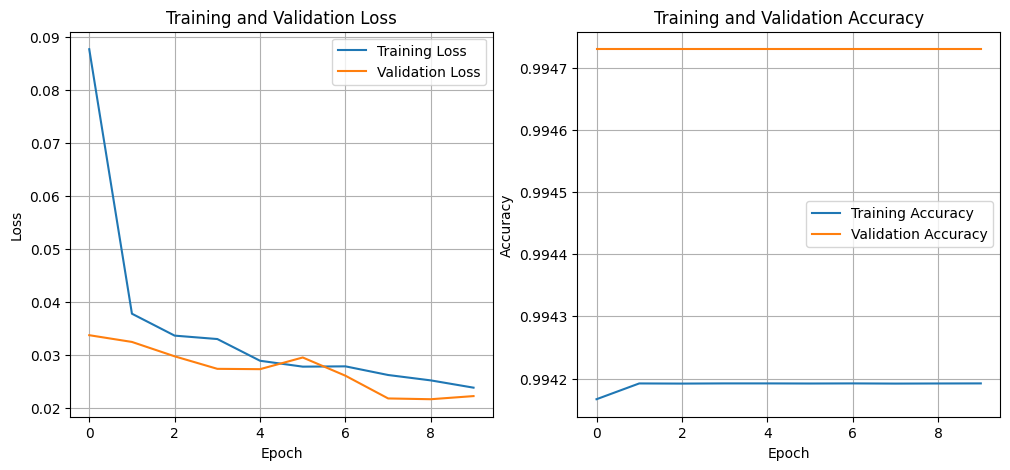

In [12]:
# Plot training dan validation loss serta accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.show()

plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


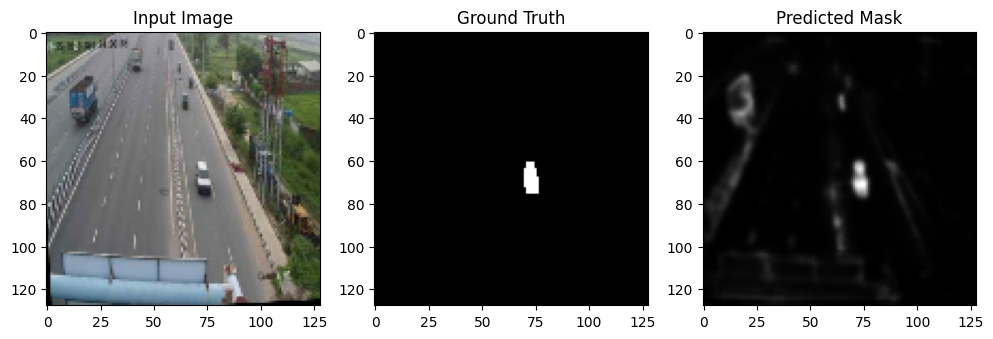

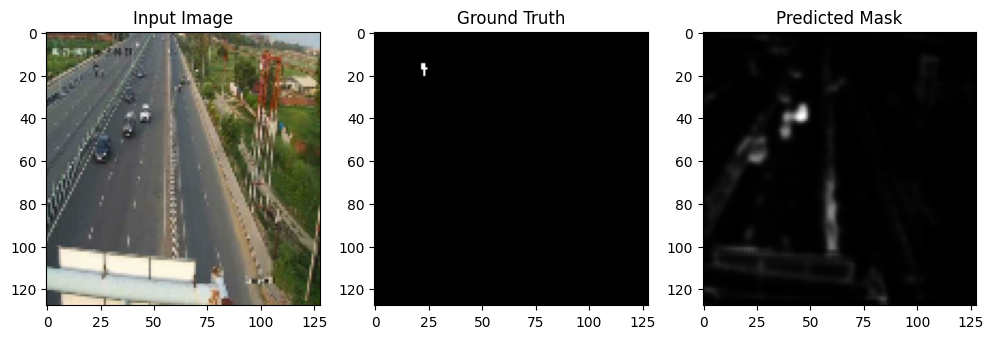

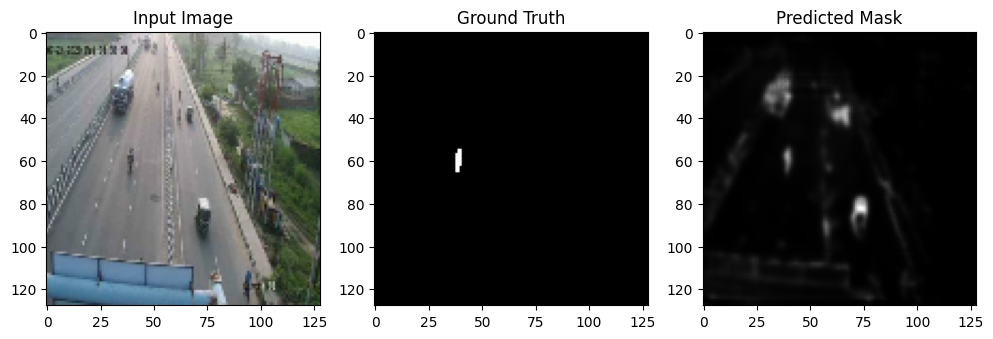

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


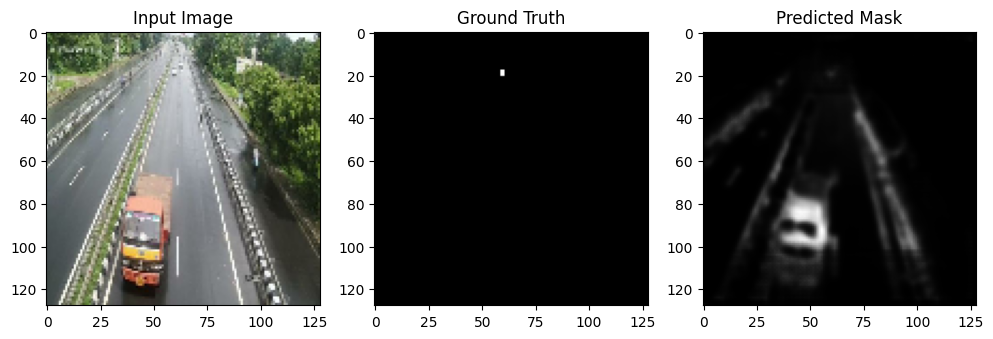

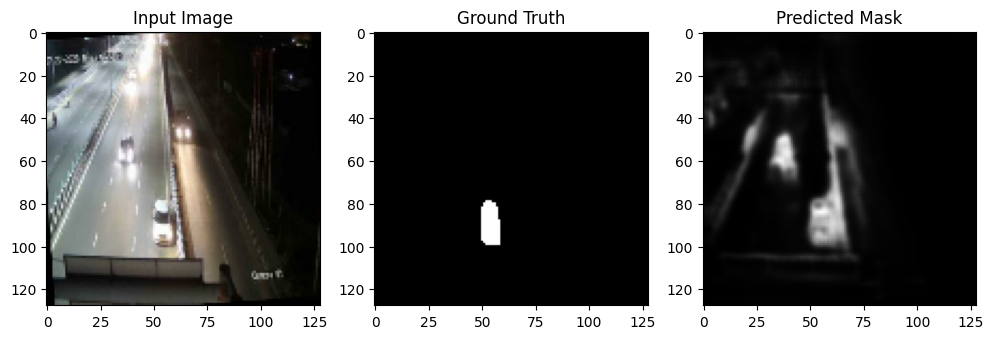

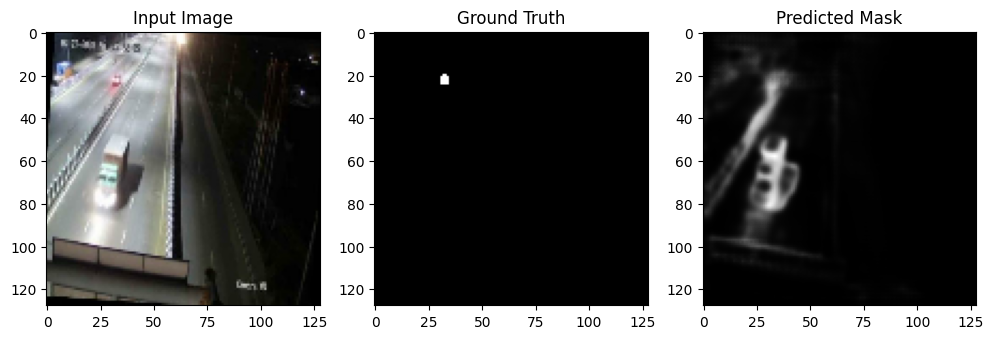

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


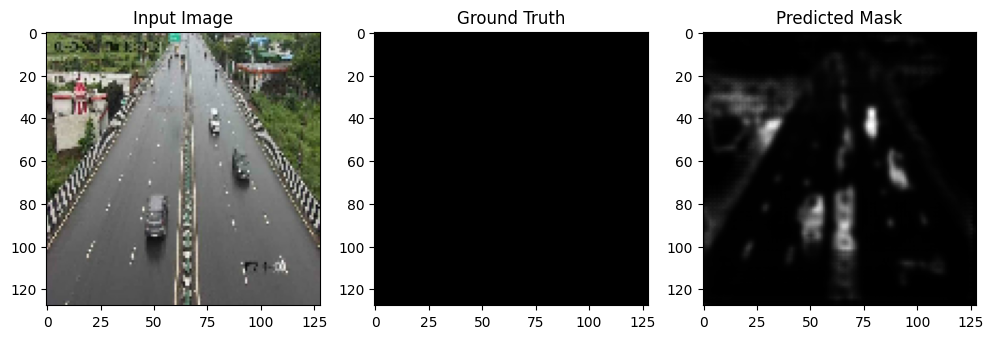

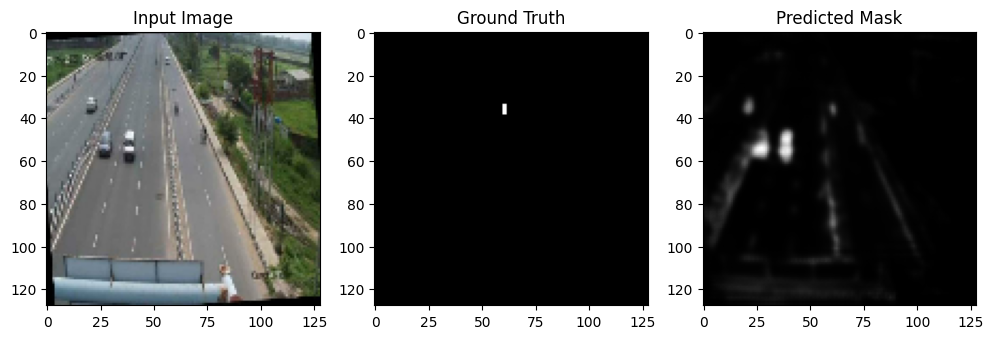

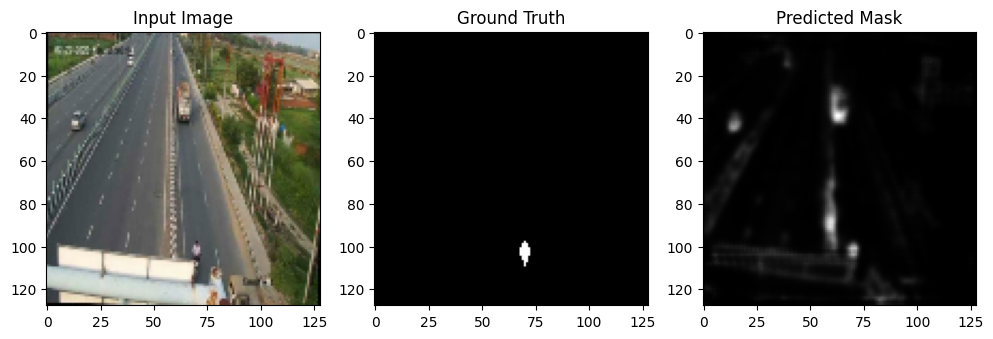

In [15]:
def display_segmentation_results(dataset, model, num_images=3):
    # Take a batch of data from the dataset
    dataset = dataset.take(num_images)
    
    for images, masks in dataset:
        predictions = model.predict(images)
        
        for i in range(num_images):
            image = images[i]
            mask = masks[i]
            prediction = predictions[i]
            
            # Plotting the results
            plt.figure(figsize=(12, 6))

            plt.subplot(1, 3, 1)
            plt.title('Input Image')
            plt.imshow(image)

            plt.subplot(1, 3, 2)
            plt.title('Ground Truth')
            plt.imshow(mask[..., 0], cmap='gray')

            plt.subplot(1, 3, 3)
            plt.title('Predicted Mask')
            plt.imshow(prediction[..., 0], cmap='gray')

            plt.show()

# Display the results for the validation dataset
display_segmentation_results(valid_dataset, unet, num_images=3)

In [24]:
# Save the model in HDF5 format
unet.save('unet_model.h5')
print("Model saved as 'unet_model.h5'")

Model saved as 'unet_model.h5'
